#  Experiments with surface heat flux

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

##  EBM with surface and atm layers

In [2]:
ebm = climlab.GreyRadiationModel(num_lev=1, num_lat=90)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=ebm.Ts.domain)
ebm.add_subprocess('insolation', insolation)
print ebm

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 1) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [3]:
#  add a fixed relative humidity process
#  (will only affect surface evaporation)
q = np.zeros_like(ebm.Tatm)
ebm.set_state('q', q)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=ebm.state, **ebm.param)
ebm.add_subprocess('H2O', h2o)

In [4]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=ebm.state, Cd=3E-4)
lhf = LatentHeatFlux(state=ebm.state, Cd=3E-4)
ebm.add_subprocess('SHF', shf)
ebm.add_subprocess('LHF', lhf)

In [5]:
ebm.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.999336878378 years.


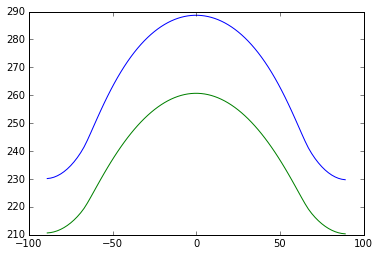

In [6]:
plt.plot(ebm.lat, ebm.Ts)
plt.plot(ebm.lat, ebm.Tatm)

## A column model approach

In [7]:
model = climlab.GreyRadiationModel(num_lev=30, num_lat=90, abs_coeff=1.6E-4)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)
print model

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [8]:
#  Convective adjustment for atmosphere only
conv = climlab.convection.convadj.ConvectiveAdjustment(state={'Tatm':model.state['Tatm']}, adj_lapse_rate=6.5,
                                                       **model.param)
model.add_subprocess('convective adjustment', conv)

In [9]:
#  add a fixed relative humidity process
#  (will only affect surface evaporation)
q = np.zeros_like(model.Tatm)
model.set_state('q', q)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=model.state, **model.param)
model.add_subprocess('H2O', h2o)

In [10]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=model.state, Cd=1E-3)
lhf = LatentHeatFlux(state=model.state, Cd=1E-3)
model.add_subprocess('SHF', shf)
model.add_subprocess('LHF', lhf)

In [11]:
model.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


In [12]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

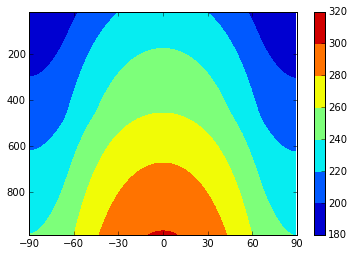

In [13]:
plot_temp_section(model, timeave=False)

In [14]:
co2model = climlab.process_like(model)
co2model.subprocess['LW'].absorptivity = model.subprocess['LW'].absorptivity*1.1

In [15]:
co2model.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.99734751351 years.


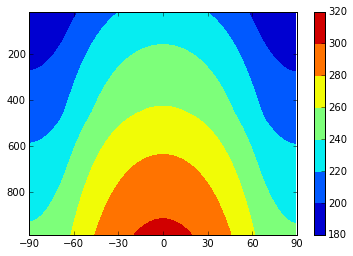

In [16]:
plot_temp_section(co2model, timeave=False)

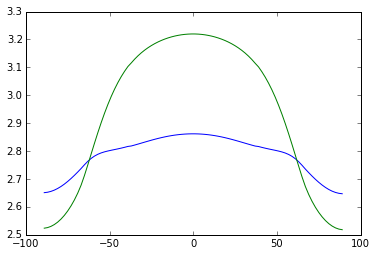

In [17]:
#  Without transport, get equatorial amplification
plt.plot(model.lat, co2model.Ts - model.Ts)
plt.plot(model.lat, co2model.Tatm[:,0] - model.Tatm[:,0])

##  Now with meridional heat tranpsort!

In [18]:
diffmodel = climlab.process_like(model)

In [19]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffmodel.Tatm.domain.heat_capacity[0]
print K

1.46414342629e-07


In [20]:
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state=diffmodel.state['Tatm'], **diffmodel.param)
diffmodel.add_subprocess('diffusion', d)
print diffmodel

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   H2O: <class 'climlab.radiation.water_vapor.FixedRelativeHumidity'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [21]:
diffmodel.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.99734751351 years.


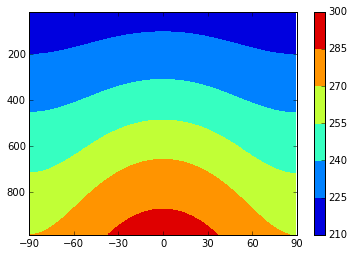

In [22]:
plot_temp_section(diffmodel)

In [23]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

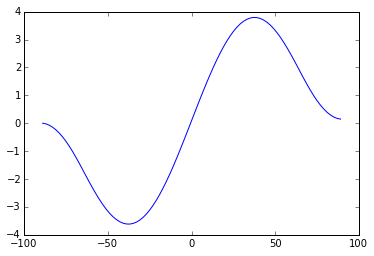

In [24]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))

In [25]:
##  Now warm it up!
co2diffmodel = climlab.process_like(diffmodel)
co2diffmodel.subprocess['LW'].absorptivity = diffmodel.subprocess['LW'].absorptivity*1.1

In [26]:
co2diffmodel.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 5.99602127027 years.


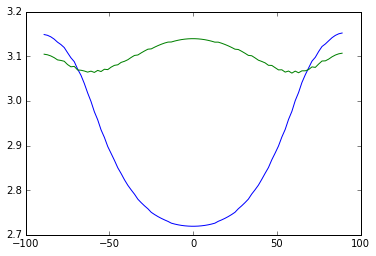

In [27]:
#  Without transport, get polar amplification...
#   of surface temperature, but not of air temperature!
plt.plot(diffmodel.lat, co2diffmodel.Ts - diffmodel.Ts)
plt.plot(diffmodel.lat, co2diffmodel.Tatm[:,0] - diffmodel.Tatm[:,0])

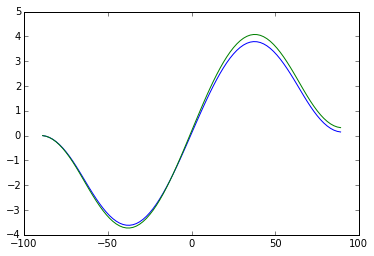

In [28]:
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffmodel.timeave['ASR'] - co2diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa_co2, diffmodel.lat))

## Same thing but with NO EVAPORATION


In [29]:
diffmodel2 = climlab.process_like(diffmodel)
diffmodel2.remove_subprocess('LHF')
print diffmodel2

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  q: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   H2O: <class 'climlab.radiation.water_vapor.FixedRelativeHumidity'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [30]:
diffmodel2.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 5.99602127027 years.


In [31]:
co2diffmodel2 = climlab.process_like(co2diffmodel)
co2diffmodel2.remove_subprocess('LHF')
co2diffmodel2.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 7.99469502703 years.


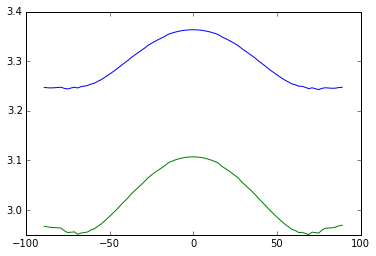

In [32]:
#  Without transport, get polar amplification...
#   of surface temperature, but not of air temperature!
plt.plot(diffmodel2.lat, co2diffmodel2.Ts - diffmodel2.Ts)
plt.plot(diffmodel2.lat, co2diffmodel2.Tatm[:,0] - diffmodel2.Tatm[:,0])

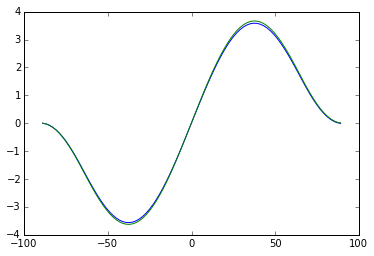

In [33]:
Rtoa = np.squeeze(diffmodel2.timeave['ASR'] - diffmodel2.timeave['OLR'])
Rtoa_co2 = np.squeeze(co2diffmodel2.timeave['ASR'] - co2diffmodel2.timeave['OLR'])
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa, diffmodel2.lat))
plt.plot(diffmodel2.lat, inferred_heat_transport(Rtoa_co2, diffmodel2.lat))

## Some stuff with Band models

In [49]:
#  Put in some ozone
import netCDF4 as nc

datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

# Taking annual, zonal average of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )

In [50]:
#  make a model on the same grid as the ozone
model1 = climlab.BandRCModel(lev=lev, lat=lat)
insolation = climlab.radiation.insolation.DailyInsolation(domains=model1.Ts.domain)
model1.add_subprocess('insolation', insolation)
print model1

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  q: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [51]:
#  Set the ozone mixing ratio
#   IMPORTANT: we need to flip the ozone array around because the vertical coordinate runs the wrong way
#   (first element is top of atmosphere, whereas our model expects the first element to be just above the surface)
O3_trans = np.transpose(O3_zon)
O3_flipped = np.fliplr(O3_trans)
# Put in the ozone
model1.absorber_vmr['O3'] = O3_flipped

In [52]:
#  Convective adjustment for atmosphere only

model1.remove_subprocess('convective adjustment')

conv = climlab.convection.convadj.ConvectiveAdjustment(state={'Tatm':model1.state['Tatm']}, **model1.param)
model1.add_subprocess('convective adjustment', conv)

In [53]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=model1.state)
lhf = LatentHeatFlux(state=model1.state)
model1.add_subprocess('SHF', shf)
model1.add_subprocess('LHF', lhf)


In [54]:
model1.step_forward()

In [24]:
model1.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.999336878378 years.


/Users/Brian/climlab/climlab/model/column.py:149: RuntimeWarning: divide by zero encountered in divide
  SW.flux_from_space)


In [25]:
model1.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.99867375676 years.


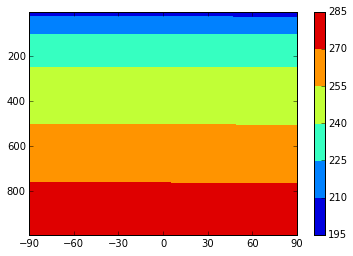

In [79]:
plot_temp_section(model1, timeave=False)

In [29]:
model1.timeave.keys()

['Tatm',
 'LHF',
 'SW_absorbed_sfc',
 'planetary_albedo',
 'LW_absorbed_sfc',
 'Ts',
 'SHF',
 'SW_emission',
 'insolation',
 'SW_absorbed_total',
 'ASR',
 'SW_up_TOA',
 'LW_up_sfc',
 'SW_up_sfc',
 'q',
 'LW_absorbed_atm',
 'OLR',
 'LW_down_sfc',
 'SW_absorbed_atm',
 'LW_emission',
 'SW_down_sfc',
 'SW_down_TOA']

In [31]:
model1.timeave['LHF']

Field([[   26.30517963],
       [   26.28465924],
       [   26.23792213],
       [   26.1901721 ],
       [   26.1916679 ],
       [   26.22712437],
       [   26.35322531],
       [   26.48843325],
       [   26.74256667],
       [   27.12920833],
       [   27.72329484],
       [   28.61379523],
       [   29.961659  ],
       [   32.19981037],
       [   35.24305027],
       [   38.78653632],
       [   42.28917319],
       [   45.22395792],
       [   47.06048398],
       [   45.17105628],
       [   39.04351694],
       [   27.65278057],
       [   10.28132132],
       [  -16.76410392],
       [  -54.84929245],
       [ -107.11890809],
       [ -177.45833671],
       [ -269.54004162],
       [ -382.27682374],
       [ -510.21408437],
       [ -650.34568655],
       [ -798.06007793],
       [ -945.26770955],
       [-1088.11276215],
       [-1227.41179701],
       [-1355.62170781],
       [-1473.17799723],
       [-1584.42038933],
       [-1690.04685259],
       [-1798.05370571],


In [55]:
model1.Tatm

Field([[ 283.98392693,  282.77475573,  280.46633718, ...,  206.81777955,
         204.30514326,  209.11536999],
       [ 283.98381433,  282.77464361,  280.46622598, ...,  206.81808966,
         204.30421479,  209.11306154],
       [ 283.9834775 ,  282.77430821,  280.46589332, ...,  206.81912168,
         204.30096755,  209.10806773],
       ..., 
       [ 283.78858694,  282.58024748,  280.2734168 , ...,  205.93743485,
         202.8379069 ,  199.734991  ],
       [ 283.78858898,  282.5802495 ,  280.2734188 , ...,  205.93806238,
         202.83864966,  199.73548038],
       [ 283.7885909 ,  282.58025141,  280.2734207 , ...,  205.93825792,
         202.83884801,  199.73557495]])

In [56]:
model1.Ts

Field([[ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.79348289],
       [ 269.793